In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [7]:
PATH_OF_DATA = '/content/gdrive/MyDrive/images'

In [8]:
import shutil
import pandas as pd
import numpy as np
import os
import math
import tensorflow as tf 
from keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.applications import ResNet50
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
import keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
#Print the categories of plant species in the image dataset

os.chdir(PATH_OF_DATA)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
for category in category_list:
  print(category)

Chilli
Bitter gourd
Lime
Mature tea tree
White Gigantic swallow wort
Ground nut
Wood-apple
Banana pepper
train
test


# Creating the Dataset

In [ ]:
#create two seperate directories for train and test proportions

data_set_dirs= ['train','test']
for dsdirs in data_set_dirs:
  path = PATH_OF_DATA + '/'+ dsdirs
  os.mkdir( path,755 )

In [ ]:
#Define the train proportion

train_prop = 0.7

In [ ]:
#Create the dataset by splitting imag dataset to train and test directories

def create_dataset():
  for ii,cat in enumerate(category_list):    
    src_path = PATH_OF_DATA + '/' + cat
    dest_dir1 = PATH_OF_DATA+'/train/'+str(ii)
    dest_dir2 = PATH_OF_DATA+'/test/'+str(ii)
    
    dest_dirs_list = [dest_dir1,dest_dir2]
    for dirs in dest_dirs_list:
      os.mkdir(dirs,755 )
    
    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    
    #get training, testing  files count
    train_count = math.ceil(train_prop*len(files))
    test_count = int((len(files)-train_count)/2)
    
    #get files to segragate for train,test data set
    train_data_list = files[0: train_count] 
    test_data_list =  files[train_count+test_count:]
       
  
    for train_data in train_data_list:
      train_path = src_path + '/' + train_data
      shutil.copy(train_path,dest_dir1)
    
    for test_data in test_data_list:
      test_path = src_path + '/' + test_data
      shutil.copy(test_path,dest_dir2)    
    
create_dataset()

In [34]:
train_dir = '/content/gdrive/MyDrive/images/train'

test_dir = '/content/gdrive/MyDrive/images/test'

In [35]:
#Apply data augmentation data generation

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 32, target_size = (224, 224), color_mode='rgb', 
                                                    classes=None, class_mode='categorical', shuffle=True, seed=None, interpolation="nearest")

test_generator = test_datagen.flow_from_directory( test_dir, batch_size = 32, target_size = (224, 224))

test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


Found 211 images belonging to 8 classes.
Found 43 images belonging to 8 classes.


In [ ]:
len(train_generator), len(test_generator)

(7, 2)

# Creating the Model

In [36]:
#load the ResNet50 base model without including the top of the network

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [37]:
#Load the weights for the base model

base_model.load_weights("/content/gdrive/My Drive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [38]:
#Freeze the layers of the base model

for layer in base_model.layers:
    layer.trainable = False

In [39]:
num_classes = 8

In [40]:
#Define a method to calculate the recall

def recall_m(y_true, y_pred):
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
     recall = true_positives / (possible_positives + K.epsilon())
     return recall

In [41]:
#Define a method to calculate precision

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [42]:
#Define a methid to calculate F1-Score

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [44]:
#Define the head model for the ResNet 50 deep neural network

head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
predictions = Dense(num_classes, activation= 'softmax')(head_model)
model = Model(inputs = base_model.input, outputs = predictions)

In [22]:
#Create and define LRFinder class to analyze the learning rate of the model

class LRFinder(Callback):
  def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
  def clr(self):
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
  def on_train_begin(self, logs=None):
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
  def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
  def plot_lr(self):
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
  def plot_loss(self):
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [45]:
epoch_size = 25
batch_size = 32

In [24]:
#Define the lr_finder with minimum and maximum learning rates

lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-2, steps_per_epoch=np.ceil(epoch_size/batch_size), epochs=3)

In [46]:
#Define the Adam optimizer

opt = Adam(lr = 1e-3, decay = 1e-3/20)

In [ ]:
#Define the Stochastic Gradient descent (SGD) optimizer

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

In [47]:
#Compile the model

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['acc', f1_m, precision_m, recall_m])

In [48]:
#Define an early stopper and a check pointer for the model

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 15)
cb_checkpointer = ModelCheckpoint(filepath = '/content/gdrive/My Drive/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [49]:
#Train the model

resnet_history = model.fit(train_generator, validation_data = test_generator, epochs = 25, 
                           steps_per_epoch=train_generator.samples/train_generator.batch_size,
                           validation_steps=test_generator.samples/test_generator.batch_size,
                           callbacks=[cb_checkpointer, cb_early_stopper])

model.load_weights("/content/gdrive/My Drive/best.hdf5")

Epoch 1/25
6/6 [==============================] - 100s 15s/step - loss: 2.5015 - acc: 0.1485 - f1_m: 0.0427 - precision_m: 0.2285 - recall_m: 0.0243 - val_loss: 1.9621 - val_acc: 0.3256 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/25
6/6 [==============================] - 88s 13s/step - loss: 2.1023 - acc: 0.2337 - f1_m: 0.0392 - precision_m: 0.2791 - recall_m: 0.0214 - val_loss: 1.8644 - val_acc: 0.4651 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/25
6/6 [==============================] - 87s 14s/step - loss: 1.9771 - acc: 0.2418 - f1_m: 0.0611 - precision_m: 0.6580 - recall_m: 0.0322 - val_loss: 1.8123 - val_acc: 0.3256 - val_f1_m: 0.1944 - val_precision_m: 1.0000 - val_recall_m: 0.1080
Epoch 4/25
6/6 [==============================] - 88s 13s/step - loss: 1.8608 - acc: 0.2789 - f1_m: 0.0886 - precision_m: 0.7444 - recall_m: 0.0489 - val_loss: 1.7542 - val_acc: 0.4186 - val_f1_m: 0.3111 - val_precis

# Model Evalution 

In [50]:
#Evaluate the model with test data

model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.5046688318252563,
 0.5116279125213623,
 0.2371794730424881,
 0.928571343421936,
 0.13920454680919647]

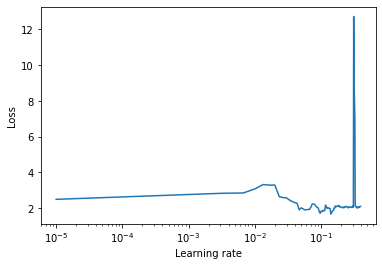

In [30]:
lr_finder.plot_loss()

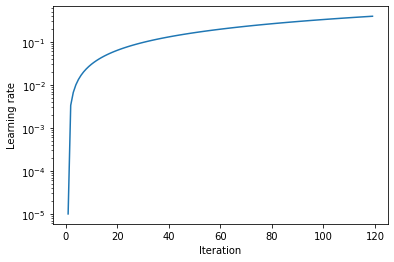

In [31]:
lr_finder.plot_lr()

In [51]:
predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [52]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [53]:
#Print a report of the metrics


report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.15      0.29      0.20         7
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.25      0.29      0.27         7
           7       0.10      0.33      0.15         6

    accuracy                           0.14        43
   macro avg       0.06      0.11      0.08        43
weighted avg       0.08      0.14      0.10        43



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


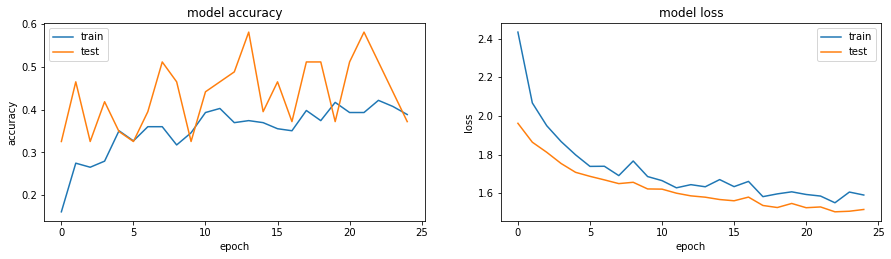

In [54]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(resnet_history.history['acc'])  
plt.plot(resnet_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 
    
plt.subplot(222)  
plt.plot(resnet_history.history['loss'])  
plt.plot(resnet_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 

plt.show()

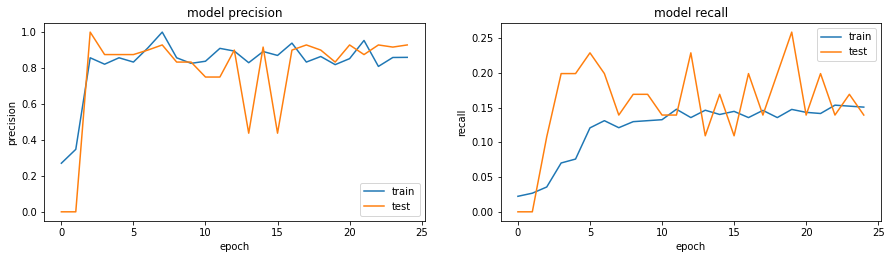

In [55]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(resnet_history.history['precision_m'])  
plt.plot(resnet_history.history['val_precision_m'])  
plt.title('model precision')  
plt.ylabel('precision')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 

plt.subplot(222)  
plt.plot(resnet_history.history['recall_m'])  
plt.plot(resnet_history.history['val_recall_m'])  
plt.title('model recall')  
plt.ylabel('recall')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 

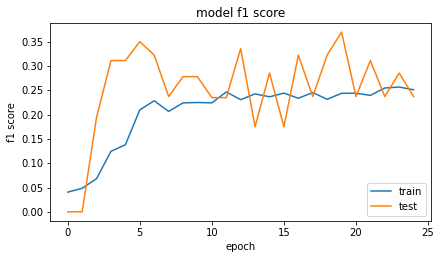

In [56]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(resnet_history.history['f1_m'])  
plt.plot(resnet_history.history['val_f1_m'])  
plt.title('model f1 score')  
plt.ylabel('f1 score')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'])

In [57]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________